In [1]:
%load_ext autoreload
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
#Import required libraries
%autoreload 2
!pip3 install --upgrade pip
!pip3 install --upgrade torch
!pip3 install torchvision
!pip3 install torchfusion
!pip3 install tensorboardx
!pip3 install pillow
!pip3 install pydicom
!pip3 install opencv-python
!pip3 install -q keras==2.2.4
!pip3 install --upgrade keras.utils
!pip3 install nibabel
#!pip3 install --upgrade tensorflow-gpu

import os
import errno
import scipy
import pydicom as dicom
import scipy.misc
import numpy as np
import tqdm
import nibabel as nib
import math
#import cv2
import datetime
from IPython.display import clear_output

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
import tensorflow.contrib.slim as slim
from tensorflow import nn, layers
from tensorflow.contrib import layers as clayers 

import keras
import keras.backend as K
from keras.layers.core import Dropout, Lambda, Dense, Flatten
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.merge import Add, Concatenate
from keras.layers import Input, Activation, Flatten, ZeroPadding2D, UpSampling2D, MaxPooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.engine import InputSpec
from keras.engine.topology import Layer
from keras.utils import conv_utils

import torch
import torch.cuda as cuda
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torch.distributions import Normal

import torchvision.utils as vutils
from torchvision import transforms, utils, datasets

from tensorboardX import SummaryWriter
from IPython import display

from PIL import Image

from getpass import getpass

Requirement already up-to-date: pip in /usr/local/lib/python3.6/site-packages (19.1)
     |████████████████████████████████| 676.9MB 94kB/s 
  Using cached https://files.pythonhosted.org/packages/fb/01/03fd7e503c16b3dc262483e5555ad40974ab5da8b9879e164b56c1f4ef6f/torchvision-0.2.2.post3-py2.py3-none-any.whl
     |████████████████████████████████| 71kB 5.4MB/s 
     |████████████████████████████████| 71kB 24.7MB/s 
     |████████████████████████████████| 133kB 17.1MB/s 
     |████████████████████████████████| 1.4MB 53.7MB/s 
     |████████████████████████████████| 204kB 45.5MB/s 
  Stored in directory: /root/.cache/pip/wheels/ee/87/ce/a5023722374ca73b57fc8d4284ba6f973c01219b3c385a07e0
  Stored in directory: /root/.cache/pip/wheels/b1/c3/d6/9a1cc8f3a99a0fc1124cae20153f36af59a6e683daca0a0814
Successfully built visdom torchfile


In [4]:
# Global image resolution.
g_res = 256

# Global number of image channels.
g_channels = 1

# Color format.
g_color_format = "L" # grayscale
if g_channels > 1:
    g_color_format = "RGB"

In [59]:
class Logger:

    def __init__(self, model_name, data_name):
        
        self.model_name = model_name
        self.data_name = data_name

        self.comment = '{}_{}'.format(model_name, data_name)
        self.data_subdir = '{}/{}'.format(model_name, data_name)

        # TensorBoard
        self.writer = SummaryWriter(comment=self.comment)

    def log(self, d_error, g_error, nrmse, psnr, ssim, epoch, n_batch, num_batches):

        # var_class = torch.autograd.variable.Variable
        if isinstance(d_error, torch.autograd.Variable):
            d_error = d_error.data.cpu().numpy()
        if isinstance(g_error, torch.autograd.Variable):
            g_error = g_error.data.cpu().numpy()

        step = Logger._step(epoch, n_batch, num_batches)
        self.writer.add_scalar(self.comment + "/D Error", d_error, step)
        self.writer.add_scalar(self.comment + "/D(G(x)) Error", g_error[0] + g_error[1], step)
        self.writer.add_scalar(self.comment + "/PSNR", psnr, step)
        self.writer.add_scalar(self.comment + "/NRMSE", nrmse, step)
        self.writer.add_scalar(self.comment + "/SSIM", ssim, step)
        #self.writer.add_scalar(self.comment + "/D(x) Loss", d_loss_real, step)
        #self.writer.add_scalar(self.comment + "/D(G(x)) Loss", d_loss_fake, step)
        #self.writer.add_scalar(self.comment + "/D(x) Accuracy", d_acc_real, step)
        #self.writer.add_scalar(self.comment + "/D(G(x)) Accuracy", d_acc_fake, step)
        #self.writer.add_scalar(self.comment + "/G_error", g_error[2], step)
        
    def add_images(self, images, nrows, direc, step, normalize):
        
        img_name = '{}/images{}'.format(self.comment, str(direc))

        # Make horizontal grid from image tensor
        horizontal_grid = vutils.make_grid(
            images, normalize=normalize, scale_each=True)

        # Add horizontal images to tensorboard
        self.writer.add_image(img_name, horizontal_grid, step)
        
    def log_images(self, generated, real, sampled, num_images, epoch, n_batch, num_batches, format='NCHW', normalize=True):
        '''
        input images are expected in format (NCHW)
        '''
        if type(generated) == np.ndarray:
            generated = torch.from_numpy(generated)
            
        if type(real) == np.ndarray:
            real = torch.from_numpy(real)
            
        if type(sampled) == np.ndarray:
            sampled = torch.from_numpy(sampled)
            
        if format=='NHWC':
            generated = generated.transpose(1,3)
            real = real.transpose(1,3)
            sampled = sampled.transpose(1, 3)

        step = Logger._step(epoch, n_batch, num_batches)
        nrows = int(np.sqrt(num_images))

        self.add_images(sampled, nrows, '/sampled', step, normalize)
        self.add_images(generated, nrows, '/generated', step, normalize)
        self.add_images(real, nrows, '/real', step, normalize)
        
        # Save plots
        #self.save_torch_images(horizontal_grid, grid, epoch, n_batch)

    def save_torch_images(self, horizontal_grid, grid, epoch, n_batch, plot_horizontal=True):
        out_dir = './data/images/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)

        # Plot and save horizontal
        fig = plt.figure(figsize=(128, 128))
        plt.imshow(np.moveaxis(horizontal_grid.numpy(), 0, -1))
        plt.axis('off')
        if plot_horizontal:
            display.display(plt.gcf())
        self._save_images(fig, epoch, n_batch, 'hori')
        plt.close()

        # Save squared
        fig = plt.figure()
        plt.imshow(np.moveaxis(grid.numpy(), 0, -1))
        plt.axis('off')
        self._save_images(fig, epoch, n_batch)
        plt.close()

    def _save_images(self, fig, epoch, n_batch, comment=''):
        out_dir = './data/images/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)
        fig.savefig('{}/{}_epoch_{}_batch_{}.png'.format(out_dir,
                                                         comment, epoch, n_batch))

    def display_status(self, epoch, num_epochs, n_batch, num_batches, d_error, g_error, d_pred_real, d_pred_fake, 
                       d_acc_real, d_acc_fake):
        
        # var_class = torch.autograd.variable.Variable
        if isinstance(d_error, torch.autograd.Variable):
            d_error = d_error.data.cpu().numpy()
        if isinstance(g_error, torch.autograd.Variable):
            g_error = g_error.data.cpu().numpy()
        if isinstance(d_pred_real, torch.autograd.Variable):
            d_pred_real = d_pred_real.data
        if isinstance(d_pred_fake, torch.autograd.Variable):
            d_pred_fake = d_pred_fake.data
        
        clear_output()
        print('Epoch: [{}/{}], Batch Num: [{}/{}]'.format(
            epoch,num_epochs, n_batch, num_batches)
             )
        print('Discriminator Loss: {:.4f}'.format(d_error))
        print('    Generator Loss: {:.4f}'.format(g_error[0] + g_error[1]))
        #print('Discriminator Loss: {:.4f}, Generator Loss: {:.4f}'.format(d_error, g_error))
        print('D(x) Loss: {:.4f}, D(G(x)) Loss: {:.4f}'.format(d_pred_real.mean(), d_pred_fake.mean()))
        print('D(x) Acc:  {:.4f}, D(G(x)) Acc:  {:.4f}'.format(d_acc_real, d_acc_fake))

    def save_models(self, generator, discriminator, epoch):
        out_dir = './data/models/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)
        torch.save(generator.state_dict(),
                   '{}/G_epoch_{}'.format(out_dir, epoch))
        torch.save(discriminator.state_dict(),
                   '{}/D_epoch_{}'.format(out_dir, epoch))

    def close(self):
        self.writer.close()

    # Private Functionality

    @staticmethod
    def _step(epoch, n_batch, num_batches):
        return epoch * num_batches + n_batch

    @staticmethod
    def _make_dir(directory):
        try:
            os.makedirs(directory)
        except OSError as e:
            if e.errno != errno.EEXIST:
                raise
                

In [6]:
class IXIDataset(Dataset):
          
    def __init__(self, transforms=None):
        
        self.transforms = transforms
        
        #get IXI Data from private BitBucket (since the data is not available publicly)
        os.chdir("/floyd/home/")
        user = getpass('BitBucket user')
        password = getpass('BitBucket password')
        os.environ['BITBUCKET_AUTH'] = user + ':' + password.replace("@", "%40")

        !git clone https://$BITBUCKET_AUTH@bitbucket.org/sidijju/IXI.git
        
        #Floydhub: 
        root = "/floyd/home/IXI/IXI-T1"

        #read in data
        num_gz = int(input("How many .gz files do you wish to use? (recommended is 5): "))
        for dirname, subdirname, filenames in os.walk(root):
            for filename in filenames[:num_gz]:
                images = nib.load(os.path.join(root, filename))
                a = images.get_fdata()
                if filename == filenames[0]:
                    self.data = a
                else:
                    self.data = np.concatenate((self.data, a), axis = 2)
            print("Data Shape", self.data.shape)

        
    def __getitem__(self, index):
        if index < np.size(self.arr,0) and index >= 0:
            if self.transforms is not None:
                self.data.add(self.transforms(self.arr[index].astype('uint8')))
            return self.data[index].astype('uint8'), index
        else:
            print("INDEX INVALID")
            return None
        
    def __len__(self):
        return self.data.shape[0]
      

In [7]:
#load custom dataset with torch

image_shape = (g_res, g_res, 1)

def ixi_data():
    DATA_FOLDER = './tf_data/MRIGAN/IXI'
    compose = transforms.Compose(
        [
            transforms.ToTensor()
        ])
    out_dir = '{}/dataset'.format(DATA_FOLDER)
    return IXIDataset(transforms = compose)

## Define Different Types of Blocks

---
We will use two types of blocks in this GAN. 

### Resnet Block


---
The Resnet block consists of two convolution and activation layers, along with a direct connection between the input and the output layer. This serves to allow more information from the original image to flow through in the neural network.

![Diagram of Resnet Block](https://cdn-images-1.medium.com/max/1200/1*ByrVJspW-TefwlH7OLxNkg.png)

### Unet


---

The Unet consists of two different segments, the encoder and decoder segments. The difference between a standard encoder decoder and a Unet is that Unet also employs residual connections similar to the Resnet block. While generally used for segmentation based tasks, the Unet will be used in this task to determine areas of the image that are incorrect and thus de-alias the image. 

![Diagram of Unet](https://gluon.mxnet.io/_images/Pixel2pixel-Unet.png)

In [8]:
def convolution_block(x, filters, kernel_size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    if activation == True:
        x = Activation("relu")(x)
    return x

def res_block(input, filters, kernel_size = (3,3), strides=(1,1), use_dropout=False):
    x = Activation("relu")(input)
    x = BatchNormalization()(x)
    x = convolution_block(x, filters, kernel_size )
    x = convolution_block(x, filters, kernel_size, activation=False)
    x = Add()([x, input])
    return x
  

## Define the Generator and the Discriminator

---

### Generator


---

The Generator model will take in an input of an aliased MRI image and output a de-aliased one. Its goal is to increase its chances of fooling the discriminator into thinking that it's producing the actual real image. 


In [9]:
#Number of filters
ngf = 64

#Input and Output number of channels
input_nc = 1
output_nc = 1

#Input Shape of the Generator
input_shape_generator = (g_res, g_res, input_nc)

def generator_model():

    inputs = Input(shape=input_shape_generator)
                          
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = Concatenate()([drop4,up6])
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = Concatenate()([conv3,up7])
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = Concatenate()([conv2,up8])
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = Concatenate()([conv1,up9])
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'tanh')(conv9)
    
    #merge10 = Add()([inputs, conv10])

    #model = Model(input = inputs, output = merge10)
    
    model = Model(input = inputs, output = conv10)

    return model

### Discriminator


---

The Discriminator determines whether the output of the Generator is a real MRI image or whether it is "fake". Its goal is to be able to tell apart generated images from real ones.

In [10]:
#Number of filters
ndf = 64

#Number of output channels
output_nc = 1

#Input Shape of Image to the Discriminator
input_shape_discriminator = (g_res, g_res, output_nc)


def discriminator_model():
    n_layers, use_sigmoid = 3, True
    inputs = Input(shape=input_shape_discriminator)

    x = Conv2D(filters=ndf, kernel_size=(4,4), strides=2, padding='same')(inputs)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.5)(x)

    nf_mult, nf_mult_prev = 1, 1
    for n in range(n_layers):
        nf_mult_prev, nf_mult = nf_mult, min(2**n, 8)
        x = Conv2D(filters=ndf*nf_mult, kernel_size=(4,4), strides=2, padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)
        x = Dropout(0.5)(x)

    nf_mult_prev, nf_mult = nf_mult, min(2**n_layers, 8)
    x = Conv2D(filters=ndf*nf_mult, kernel_size=(4,4), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.5)(x)

    x = Conv2D(filters=1, kernel_size=(4,4), strides=1, padding='same')(x)
    if use_sigmoid:
        x = Activation('sigmoid')(x)

    x = Flatten()(x)
    x = Dense(1024, activation='tanh')(x)
    x = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=x, name='Discriminator')
    return model

## Putting It all Together


---

In this segment we combine the generator and discriminator models and define losses for each of them. Since this model has to have the generated images be as close to the real ones as possible, we have to have the outputs of the generated images in the final model.

In [11]:
def gendis_mult_out(generator, discriminator):
    inputs = Input(shape=(g_res, g_res, 1))
    generated_images = generator(inputs)
    outputs = discriminator(generated_images)
    model = Model(inputs=inputs, outputs=[generated_images, outputs])
    return model

### Losses


---

We will use multiple losses in the model. 
#### Wasserstein Loss


---


Wasserstein Loss is similar to Mean Squared Error in that it finds the mean of the differences between two images. It is known to improve GAN performance.

In [12]:
def w_loss(y_true, y_pred):
    return K.mean(y_true - y_pred)

#### Perceptual Loss


---

Perceptual Loss uses the classic VGG16 architecture to determine similarity between images.

In [13]:
from keras.applications.vgg16 import VGG16

def perceptual_loss(y_true, y_pred):
    vgg = VGG16(include_top=False, weights='imagenet', input_shape=(g_res, g_res, 3))
    loss_model = Model(inputs=vgg.input, outputs=vgg.get_layer('block3_conv3').output)
    loss_model.trainable = False
    if g_channels == 1:
        y_true = K.concatenate((y_true, y_true, y_true), axis = 3)
        y_pred = K.concatenate((y_pred, y_pred, y_pred), axis = 3)
    #print("y_true: ", y_true)
    #print("y_pred: ", y_pred)
    loss_model_true = loss_model(y_true)
    loss_model_pred = loss_model(y_pred)
    mean = K.mean(K.square(loss_model_true - loss_model_pred))
    #print("kmean: ", loss_model_true, loss_model_pred, mean)
    return K.mean(K.square(loss_model(y_true) - loss_model(y_pred)))

#### Mean Squared Error

___

MSE calculates the pixel by pixel loss from the true output to the fake one. 

In [14]:
def mse(y_true, y_pred):
    total = np.sum(np.square(np.subtract(y_true, y_pred)))/(g_res ** 2)
    #print("mse: ", total)
    return total
                

In [15]:
def fft_mse(y_true, y_pred):
    y_true_fft = tf.spectral.fft3d(tf.cast(y_true, tf.complex64))
    y_pred_fft = tf.spectral.fft3d(tf.cast(y_pred, tf.complex64))
    total = mse(tf.cast(y_true_fft, tf.float32), 
                tf.cast(y_pred_fft, tf.float32))
    #print("fft_mse: ", total)
    return total

In [16]:
def g_loss(y_true, y_pred):
    mse_loss = mse(y_true, y_pred)
    perc_loss = perceptual_loss(y_true, y_pred)
    fft_loss = fft_mse(y_true, y_pred)
    return mse_loss + perc_loss + fft_loss

## Training the Model


---

We have now arrived at the final step of the GAN: defining the dataset and training the model. 

### Dataset


---

We will load in the OASIS Dataset using the custom class defined above. Since OASIS data is not public, I used a Bitbucket login to access the data and pull it into this notebook. This notebook will not work without that data. 

We will also define a method of removing information from the images in order to get aliased MRI images. This data will be x_train. 

The real images themselves will be y_train.

In [17]:
from scipy import fftpack

def plot_fft(im, fig):
    plt.grid(False)
    plt.imshow(np.abs(im), cmap='gray')
    
def plot_kspace(im, fig):
    plt.grid(False)
    plt.imshow(np.abs(im), norm=LogNorm(vmin=5), cmap='gray')

In [18]:
dataset = ixi_data()

BitBucket user ·······
BitBucket password ···············


fatal: destination path 'IXI' already exists and is not an empty directory.


How many .gz files do you wish to use? (recommended is 5):  2


Data Shape (256, 256, 300)


In [19]:
from matplotlib.colors import LogNorm

def norm_img(img):
    maxv = np.max(img)
    img = img * 255 / maxv
    img = (img - 127.5) / 127.5
    return img

def process_img(im, display = False, sampling_rate = 2, title = "Image, K-space, Undersampled K-space, and Reconstruction"):

    #sample original k-space image
    im_fft = fftpack.fft2(im)
    im_recon = fftpack.ifft2(im_fft)

    im_sampled = np.zeros((g_res, g_res))
    for i in range(g_res//sampling_rate):
        im_sampled[sampling_rate*i] = im_fft[sampling_rate*i]
    for j in range(1, sampling_rate):
        im_sampled[sampling_rate*i+j] = np.ones((1, g_res))

    im_recon_sampled = fftpack.ifft2(im_sampled)

    # Now shift the quadrants around so that low spatial frequencies are in
    # the center of the 2D fourier transformed image.
    im_fft2 = fftpack.fftshift(im_fft)
    im_sampled2 = fftpack.fftshift(im_sampled)

    if display is True:
        ### Display Image Data ###  
        fig = plt.figure(figsize = (10, 10))
        fig.suptitle(title, fontsize = 16)
        fig.add_subplot(221)
        plot_fft(im_recon, fig)
        fig.add_subplot(222)
        plot_kspace(im_fft2, fig)
        fig.add_subplot(223)
        plot_kspace(im_sampled2, fig)
        fig.add_subplot(224)
        plot_fft(im_recon_sampled, fig)
        plt.show()

    return im_recon_sampled

def get_data_simple_IXI(dataset, title = "Image, K-space, Undersampled K-space, and Reconstruction: S = 2" , sampling_rate = 2, display = False):
  
    y = dataset.data
    x = np.empty((g_res, g_res, y.shape[2]))

    for i in range(y.shape[2]):
        x[:, :, i] = process_img(y[:, :, i], sampling_rate = sampling_rate)

    process_img(y[:, :, round(y.shape[0]/3)], display, sampling_rate = sampling_rate, title = title)

    # jb normalize image data for neural networks.
    x = norm_img(x)
    y = norm_img(y)

    # jb convert to RGB.
    if g_channels > 1:
        x = np.squeeze(np.stack((x,)*3, axis=-1))
        y = np.squeeze(np.stack((y,)*3, axis=-1))
        x = tf.convert_to_tensor(x)
        
        y = tf.convert_to_tensor(y)

    return x, y

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:50: ComplexWarning: Casting complex values to real discards the imaginary part


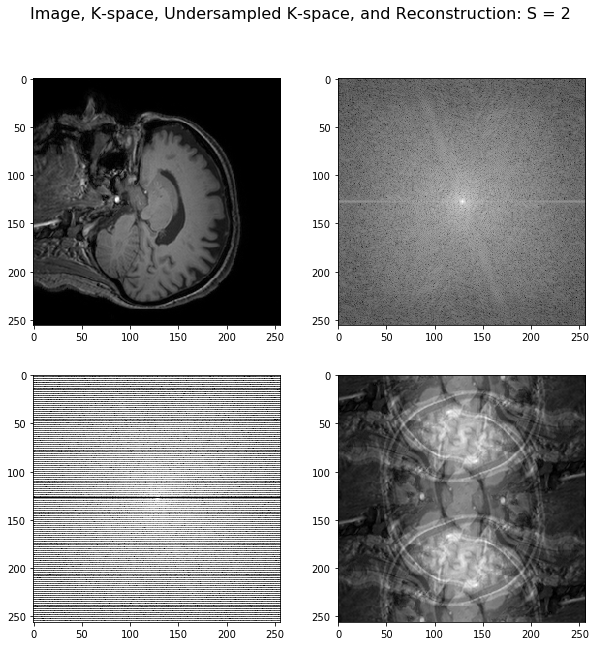

(array([[[-0.99998799, -0.99998799, -0.99691225, ..., -0.9892229 ,
          -0.98768502, -0.9892229 ],
         [-0.99923106, -0.99923106, -0.99769319, ..., -1.        ,
          -0.99538639, -0.98769704],
         [-1.        , -0.99923106, -0.99846213, ..., -0.99538639,
          -0.99769319, -0.9869281 ],
         ...,
         [-0.99769319, -1.        , -0.99923106, ..., -0.99154171,
          -0.99154171, -0.99231065],
         [-1.        , -0.99923106, -0.99846213, ..., -0.99538639,
          -0.99769319, -0.9869281 ],
         [-0.99923106, -0.99923106, -0.99769319, ..., -1.        ,
          -0.99538639, -0.98769704]],
 
        [[-0.99921905, -0.99921905, -0.99768118, ..., -0.99229864,
          -0.99383651, -0.97922674],
         [-0.99846213, -1.        , -0.99846213, ..., -0.99077278,
          -0.99154171, -0.98615917],
         [-0.99769319, -1.        , -0.99769319, ..., -0.99154171,
          -0.99077278, -0.99461745],
         ...,
         [-0.99923106, -0.9992310

In [20]:
get_data_simple_IXI(dataset, sampling_rate = 2, display = True)
    

### Models and Optimizers


---

Here we will initialize the Generator and Discriminator models and also define the optimizers for each. We will also define functions for metrics that the model will keep track of, but NOT train on over time (SSIM, NMSE, PSNR). 

#### PSNR

PSNR or Peak Signal-to-Noise Ratio is a measure of the noise introduced by error between two given images. The closer PSNR is to 100, the better quality the reconstruction is.

In [21]:
def psnr(y_true, y_pred):
    mse_val = mse(y_true, y_pred)
    if mse_val == 0:
        return 100
    return math.log10(255.0/mse_val)

#### NRMSE

NRMSE or Normalized Root MSE is a version of MSE that takes into account the images it compares. The closer NRMSE is to 0, the better.

In [50]:
from skimage.measure import compare_nrmse as nrmse

#### SSIM

In [23]:
from skimage.measure import compare_ssim as ssim

### Compiling and Training

---

In this last step, we will compile our models with the losses we defined and train them. 

Now we will process and define the batches of images.

In [24]:
currEpoch = 329

EPOCH_NUM = 40

BATCH_SIZE = 4

SAMPLING_RATE = 50

In [25]:
# Initialize models
from keras.utils import plot_model
g = generator_model()
#plot_model(g, to_file='generator_name.png', show_shapes=True, show_layer_names=True)
g.load_weights("generator_norm_sr50_" + str(currEpoch) + ".h5")
print("GENERATOR")
g.summary()

d = discriminator_model()
#plot_model(d, to_file='discriminator_name.png', show_shapes=True, show_layer_names=True)
d.load_weights("discriminator_norm_sr50_" + str(currEpoch) + ".h5")
print("DISCRIMINATOR")
d.summary()

d_on_g = gendis_mult_out(g, d)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


GENERATOR
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________


In [26]:
def save_all_weights(d, g, epoch_number, current_loss):
    now = datetime.datetime.now()
    os.chdir("/floyd/home/")
    save_dir = os.path.join("weights/", '{}_{}_{} run'.format(now.month, now.day, now.year))
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    g.save_weights(os.path.join(save_dir, 'generator_norm_sr{}_{}.h5'.format(SAMPLING_RATE, epoch_number + currEpoch)), True)
    d.save_weights(os.path.join(save_dir, 'discriminator_norm_sr{}_{}.h5'.format(SAMPLING_RATE, epoch_number + currEpoch)), True)

In [27]:
# Initialize optimizers
g_opt = Adam(epsilon=1E-4)
#lr - sr2 - 1E-4
d_opt = Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
d_on_g_opt = Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

# Compile models
d.trainable = True
d.compile(optimizer=d_opt, loss=w_loss)
d.trainable = False

loss = [g_loss, w_loss]
loss_weights = [100, 1]
d_on_g.compile(optimizer=d_on_g_opt, loss=loss, loss_weights=loss_weights)
d.trainable = True

58892288/58889256 [==============================] - 3s 0us/step


In [60]:
output_true_batch, output_false_batch = np.random.uniform(low = 0.9, high = 1.0, size = (BATCH_SIZE, 1)), np.zeros((BATCH_SIZE, 1))

logger = Logger(model_name='MRIGAN Trial 16.2 SR ' + str(SAMPLING_RATE) + '%', data_name='IXI')

In [28]:
x_train, y_train = get_data_simple_IXI(dataset, sampling_rate = int(100/SAMPLING_RATE))

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:50: ComplexWarning: Casting complex values to real discards the imaginary part


In [66]:
for epoch in tqdm.tqdm(range(EPOCH_NUM)):
    
    num_samples = int(x_train.shape[2])
    
    permutated_indexes = np.random.permutation(num_samples)
    num_batches = int(num_samples / BATCH_SIZE)
    
    d_losses = []
    d_on_g_losses = []
    
    for n_batch in range(num_batches):
        batch_indexes = permutated_indexes[n_batch*BATCH_SIZE:(n_batch+1)*BATCH_SIZE]

        sampled_batch = K.eval(K.expand_dims(np.rollaxis(x_train[:, :, batch_indexes], 2, 0), axis = -1))
        full_batch = K.eval(K.expand_dims(np.rollaxis(y_train[:, :, batch_indexes], 2, 0), axis = -1))

        generated_images = g.predict(x=sampled_batch, batch_size=BATCH_SIZE)

        d_loss_real = d.train_on_batch(full_batch, output_true_batch)
        d_loss_fake = d.train_on_batch(generated_images, output_false_batch)
        d_loss = 0.5 * np.add(d_loss_fake, d_loss_real)
        d_losses.append(d_loss)

        d.trainable = False

        d_on_g_loss = d_on_g.train_on_batch(sampled_batch, [full_batch, output_true_batch])
        d_on_g_losses.append(d_on_g_loss)

        d.trainable = True
        
        nrmse_val = 0
        psnr_val = 0
        ssim_val = 0
        for i in range(BATCH_SIZE):
            nrmse_val += nrmse(full_batch[i][:, :, 0], generated_images[i][:, :, 0])
            psnr_val += psnr(full_batch[i][:, :, 0], generated_images[i][:, :, 0])
            ssim_val += ssim(full_batch[i][:, :, 0], generated_images[i][:, :, 0], data_range = 255)
            
        nrmse_val /= BATCH_SIZE
        psnr_val /= BATCH_SIZE
        ssim_val /= BATCH_SIZE
        
        logger.log(d_loss, d_on_g_loss, nrmse_val, psnr_val, ssim_val, epoch, n_batch, num_batches) 
        logger.log_images(generated_images, full_batch, sampled_batch, BATCH_SIZE, epoch, n_batch, num_batches, format='NHWC')   
    
    #logger.display_status(epoch, EPOCH_NUM, n_batch, num_batches, d_loss, d_on_g_loss, d_loss_real, d_loss_fake)
        
       
    #print(np.mean(d_losses), np.mean(d_on_g_losses))
    with open('log.txt', 'a+') as f:
        f.write('{} - {} - {}\n'.format(epoch, np.mean(d_losses), np.mean(d_on_g_losses)))

    save_all_weights(d, g, epoch, int(np.mean(d_on_g_losses)))



  0%|          | 0/40 [00:00<?, ?it/s]

  2%|▎         | 1/40 [01:14<48:20, 74.38s/it]

  5%|▌         | 2/40 [02:31<47:35, 75.14s/it]

  8%|▊         | 3/40 [03:49<46:51, 75.99s/it]

 10%|█         | 4/40 [05:07<45:56, 76.58s/it]

 12%|█▎        | 5/40 [06:25<44:55, 77.03s/it]

KeyboardInterrupt: 

#### Testing

In [20]:
file = ["generator_norm_sr50_198.h5", "generator_norm_sr50_237.h5", "generator_norm_sr50_251.h5", "generator_norm_sr50_290.h5", "generator_norm_sr50_329.h5"]

In [21]:
dataset = ixi_data()
x_train, y_train = get_data_simple_IXI(dataset)
x_train_t = K.eval(K.expand_dims(np.rollaxis(x_train[:, :, :], 2, 0), axis = -1))
y_train_t = K.eval(K.expand_dims(np.rollaxis(y_train[:, :, :], 2, 0), axis = -1))

BitBucket user ·······
BitBucket password ···············


fatal: destination path 'IXI' already exists and is not an empty directory.


How many .gz files do you wish to use? (recommended is 5):  5


Data Shape (256, 256, 742)


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:50: ComplexWarning: Casting complex values to real discards the imaginary part


In [22]:
def statsGen(num, rangenum, generated_images):
    for i in range(num, num + rangenum):
        fig = plt.figure(figsize = (10, 10))
        fig.add_subplot(241)
        plt.title("Sampled")
        plt.axis('off')
        plt.imshow(np.rot90(x_train[:,:, i]), cmap = 'gray')
        
        fig.add_subplot(242)
        plt.title("Generated")
        plt.axis('off')
        plt.imshow(np.rot90(generated_images[i, :, :, 0]), cmap = 'gray')
        
        fig.add_subplot(243)
        plt.title("Actual")
        plt.axis('off')
        plt.imshow(np.rot90(y_train[:, :, i]), cmap = 'gray')
        
        fig.add_subplot(244) #generated image diff
        plt.title("Difference")
        plt.axis('off')
        plt.imshow(np.rot90(np.abs(np.abs(generated_images[i, :, :, 0]) - np.abs(y_train[:, :, i]))), cmap = 'hot')
        '''
        kreal = fftpack.fft2(y_train[:, :, i])
        ksampled = fftpack.fft2(x_train[:, :, i])
        kgen = fftpack.fft2(generated_images[i, :, :, 0])
        
        kreal = fftpack.fftshift(kreal)
        ksampled = fftpack.fftshift(ksampled)
        kgen = fftpack.fftshift(kgen)
        
        fig.add_subplot(245)
        plt.title("Sampled k-space")
        plt.axis('off')
        plot_fft(np.rot90(ksampled), fig)
        
        fig.add_subplot(246)
        plt.title("Generated k-space")
        plt.axis('off')
        plot_fft(np.rot90(kgen), fig)
        
        fig.add_subplot(247)
        plt.title("Actual k-space")
        plt.axis('off')
        plot_fft(np.rot90(kreal), fig)
        
        fig.add_subplot(248) #generated image diff
        plt.title("Difference in k-space")
        plt.axis('off')
        plt.imshow(np.rot90(np.abs(np.abs(kgen) - np.abs(kreal))), cmap = 'hot')
        '''
        plt.show()

In [23]:
num = 230
rangenum = 1

In [24]:
generator = generator_model()
generator.load_weights(file[4])
generated_images = generator.predict(x=x_train_t, batch_size = 4)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


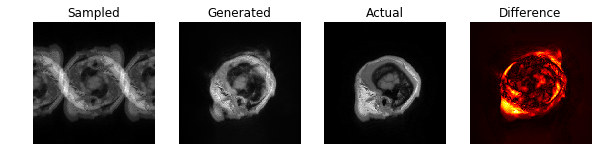

In [29]:
statsGen(20, 1, generated_images)

In [32]:
from sklearn import metrics
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

In [33]:
data = np.concatenate((y_train_t, generated_images), axis = 0)
labels = [1 for x in range(len(y_train_t))]
labels = np.concatenate((labels, [0 for x in range(len(generated_images))]), axis = 0)

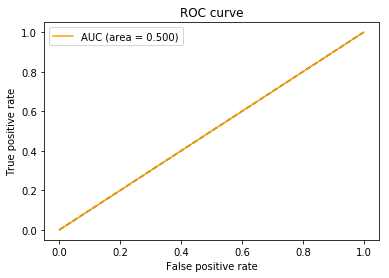

In [34]:
disc = discriminator_model()
disc.load_weights("discriminator_norm_sr50_290.h5")
y_pred_keras = disc.predict(data).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(labels, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, color = 'orange', label='AUC (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

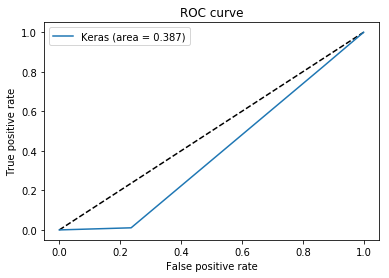

In [35]:
disc = discriminator_model()
disc.load_weights("discriminator_13.h5")
y_pred_keras = disc.predict(data).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(labels, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

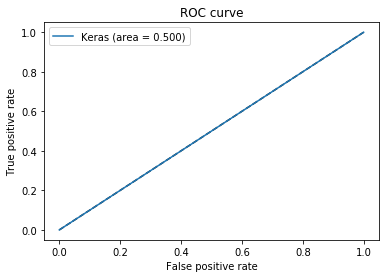

In [36]:
disc = discriminator_model()
disc.load_weights("discriminator_50.h5")
y_pred_keras = disc.predict(data).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(labels, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()